In [ ]:
# Install required packages
!pip install librosa tensorflow tensorflow_hub scikit-learn matplotlib

# Import libraries
import os
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
from sklearn.model_selection import train_test_split
from google.colab import files
import librosa
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Masking
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pickle
import matplotlib.pyplot as plt

# Load YAMNet model
yamnet_model_handle = 'https://tfhub.dev/google/yamnet/1'
yamnet_model = hub.load(yamnet_model_handle)

# Function to preprocess audio for YAMNet
def preprocess_audio(file_path):
    waveform, sr = librosa.load(file_path, sr=16000, mono=True)  # Resample to 16kHz mono
    return waveform

# Function to get embeddings from YAMNet
def get_embeddings(audio):
    scores, embeddings, _ = yamnet_model(audio)
    return embeddings.numpy()  # Return sequence of embeddings (time_steps, 1024)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def load_from_drive(folder_path, label):
    print(f"Loading audio files from: {folder_path}")
    features, labels = [], []

    audio_files = [f for f in os.listdir(folder_path) if f.endswith('.wav') or f.endswith('.mp3')]

    for file_name in audio_files:
        file_path = os.path.join(folder_path, file_name)
        waveform = preprocess_audio(file_path)
        embeddings = get_embeddings(tf.convert_to_tensor(waveform, dtype=tf.float32))
        features.append(embeddings)
        labels.append(label)

    print(f"Loaded {len(audio_files)} files from {folder_path}")
    return features, labels

def handle_data():
    if os.path.exists("data.pkl"):
        choice = input("Do you want to load new data from Drive or use existing data? (load/new): ").strip().lower()
        if choice == "new":

            positive_path = '/content/drive/My Drive/Dataset_final/Pneumonia_positive'
            positive_features, positive_labels = load_from_drive(positive_path, 1)


            negative_path = '/content/drive/My Drive/Dataset_final/Pneumonia_negative'
            negative_features, negative_labels = load_from_drive(negative_path, 0)


            X = positive_features + negative_features
            y = positive_labels + negative_labels


            with open("data.pkl", "wb") as f:
                pickle.dump((X, y), f)
            print("Data saved as data.pkl")
        elif choice == "load":
            with open("data.pkl", "rb") as f:
                X, y = pickle.load(f)
            print("Data loaded from data.pkl")
        else:
            print("Invalid input. Defaulting to loading existing data.")
            with open("data.pkl", "rb") as f:
                X, y = pickle.load(f)
            print("Data loaded from data.pkl")
    else:
        print("No existing data found. Loading new data from Drive.")

        positive_path = '/content/drive/My Drive/Dataset_final/Pneumonia_positive'
        positive_features, positive_labels = load_from_drive(positive_path, 1)

        negative_path = '/content/drive/My Drive/Dataset_final/Pneumonia_negative'
        negative_features, negative_labels = load_from_drive(negative_path, 0)

        X = positive_features + negative_features
        y = positive_labels + negative_labels

        with open("data.pkl", "wb") as f:
            pickle.dump((X, y), f)
        print("Data saved as data.pkl")

    return X, y

X, y = handle_data()


No existing data found. Loading new data from Drive.
Loading audio files from: /content/drive/My Drive/Dataset_final/Pneumonia_positive
Loaded 323 files from /content/drive/My Drive/Dataset_final/Pneumonia_positive
Loading audio files from: /content/drive/My Drive/Dataset_final/Pneumonia_negative
Loaded 280 files from /content/drive/My Drive/Dataset_final/Pneumonia_negative
Data saved as data.pkl


In [ ]:
# Pad sequences to the same length (required for LSTM)
X_padded = pad_sequences(X, padding='post', dtype='float32')  # Pads to max length
X_padded = np.array(X_padded)  # Convert to numpy array
y = np.array(y)

# Split the dataset: 70% Training, 30% Testing (including validation)
X_train, X_temp, y_train, y_temp = train_test_split(X_padded, y, test_size=0.3, random_state=42)
X_test, y_test = X_temp, y_temp  # Test split


In [ ]:
model = Sequential()

model.add(Masking(mask_value=0.0, input_shape=(X_padded.shape[1], 1024)))

model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.5))

model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.3))

model.add(LSTM(64, return_sequences=False))
model.add(Dropout(0.5))

model.add(Dense(32, activation='tanh'))
model.add(Dropout(0.3))

model.add(Dense(1, activation='sigmoid'))

optimizer = tf.keras.optimizers.Adam(learning_rate=0.005)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
import os
import pickle
import numpy as np
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Masking, LSTM, Dropout, Dense
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import SGD
from sklearn.model_selection import train_test_split

def load_latest_data():
    if os.path.exists("data.pkl"):
        with open("data.pkl", "rb") as f:
            X, y = pickle.load(f)
            print("Latest data loaded from data.pkl")
            return X, y
    else:
        raise FileNotFoundError("data.pkl not found. Please upload or create the data file.")

X, y = load_latest_data()
X_padded = pad_sequences(X, padding='post', dtype='float32')
X_padded = np.array(X_padded)
y = np.array(y)
X_train, X_temp, y_train, y_temp = train_test_split(X_padded, y, test_size=0.3)
X_train = X_train[:int(0.5 * len(X_train))]
y_train = y_train[:int(0.5 * len(y_train))]
X_test, y_test = X_temp, y_temp

model_choice = input("Do you want to use an existing model or train a new one? (use/train): ").strip().lower()
if model_choice == "train":
    model = Sequential()
    model.add(Masking(mask_value=0.0, input_shape=(X_padded.shape[1], 1024)))
    model.add(LSTM(16, return_sequences=True))
    model.add(Dropout(0.3))
    model.add(LSTM(32, return_sequences=False))
    model.add(Dense(8, activation="relu"))
    model.add(Dense(1, activation="sigmoid"))

    optimizer = SGD(learning_rate=0.05)
    model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"])
    history = model.fit(X_train, y_train, epochs=100, batch_size=128, validation_data=(X_test, y_test))
    model.save("pneumonia_detection_model_reduced_accuracy_v3.h5")
    print("Model saved as pneumonia_detection_model_reduced_accuracy_v3.h5")

    with open("history.pkl", "wb") as f:
        pickle.dump(history.history, f)
    print("Training history saved as history.pkl")
elif model_choice == "use":
    if os.path.exists("pneumonia_detection_model_reduced_accuracy_v3.h5"):
        model = load_model("pneumonia_detection_model_reduced_accuracy_v3.h5")
        print("Model loaded from pneumonia_detection_model_reduced_accuracy_v3.h5")
    else:
        raise FileNotFoundError("No existing model found. Please train a new model.")
else:
    print("Invalid input. Defaulting to using an existing model.")
    if os.path.exists("pneumonia_detection_model_reduced_accuracy_v3.h5"):
        model = load_model("pneumonia_detection_model_reduced_accuracy_v3.h5")


Latest data loaded from data.pkl
Do you want to use an existing model or train a new one? (use/train): train
Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.4408 - loss: 0.6919 - val_accuracy: 0.5967 - val_loss: 0.6774
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 525ms/step - accuracy: 0.5888 - loss: 0.6757 - val_accuracy: 0.6077 - val_loss: 0.6683
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 684ms/step - accuracy: 0.6144 - loss: 0.6680 - val_accuracy: 0.6630 - val_loss: 0.6620
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 877ms/step - accuracy: 0.6867 - loss: 0.6597 - val_accuracy: 0.7569 - val_loss: 0.6568
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.7539 - loss: 0.6544 - val_accuracy: 0.8011 - val_loss: 0.6512
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 913ms/step - accuracy: 0.7996 - loss: 0.6486 - val_accuracy: 0.8398 - val_loss: 0.6443
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step - accuracy: 0.8238 - loss: 0.6394 - val_accuracy: 0.8840 - val_loss: 0.6392
Epoch 8/

Model saved as pneumonia_detection_model_reduced_accuracy_v3.h5
Training history saved as history.pkl
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.9804 - loss: 0.1280
Test Loss: 0.13094674050807953
Test Accuracy: 0.9779005646705627


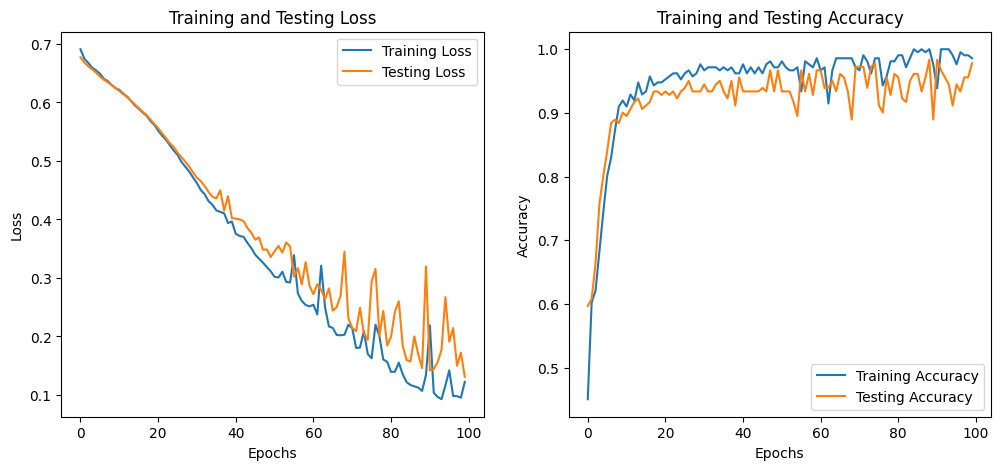

Evaluating the model on test data...
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step


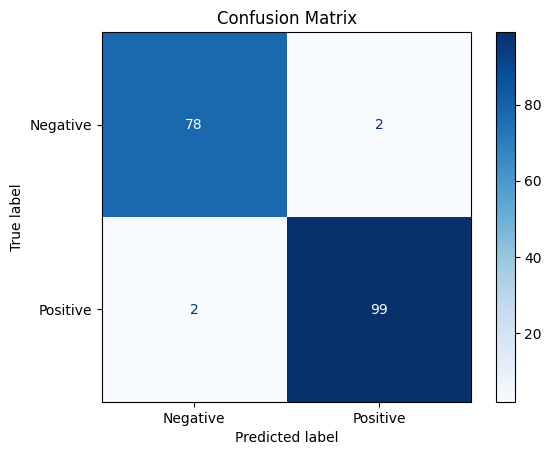

Classification Report:
              precision    recall  f1-score   support

    Negative       0.97      0.97      0.97        80
    Positive       0.98      0.98      0.98       101

    accuracy                           0.98       181
   macro avg       0.98      0.98      0.98       181
weighted avg       0.98      0.98      0.98       181



In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# Plot training and testing loss and accuracy
if os.path.exists("history.pkl"):
    with open("history.pkl", "rb") as f:
        history = pickle.load(f)

    # Initialize subplots
    plt.figure(figsize=(12, 5))

    # Plot: Training and Testing Loss
    plt.subplot(1, 2, 1)
    plt.plot(history['loss'], label='Training Loss')  # Training Loss
    plt.plot(history['val_loss'], label='Testing Loss')  # Testing Loss
    plt.title('Training and Testing Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot: Training and Testing Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history['accuracy'], label='Training Accuracy')  # Training Accuracy
    plt.plot(history['val_accuracy'], label='Testing Accuracy')  # Testing Accuracy
    plt.title('Training and Testing Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

# Evaluate model and display confusion matrix, F1 score, recall, and precision
def evaluate_and_report_metrics():
    print("Evaluating the model on test data...")
    y_pred_probs = model.predict(X_test)  # Predict probabilities
    y_pred = (y_pred_probs > 0.5).astype(int)  # Convert probabilities to binary predictions

    # Calculate confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # Display confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative", "Positive"])
    disp.plot(cmap="Blues")
    plt.title("Confusion Matrix")
    plt.show()

    # Classification metrics
    print("Classification Report:")
    report = classification_report(y_test, y_pred, target_names=["Negative", "Positive"])
    print(report)

# Test with a new file
def test_new_file():
    print("Upload a new audio file for testing:")
    new_file = files.upload()
    for file_name in new_file.keys():
        waveform = preprocess_audio(file_name)
        embeddings = get_embeddings(tf.convert_to_tensor(waveform, dtype=tf.float32))
        padded_embeddings = pad_sequences([embeddings], maxlen=X_padded.shape[1], padding='post', dtype='float32')
        prediction = model.predict(padded_embeddings)
        label = "Pneumonia Positive" if prediction[0] > 0.5 else "Pneumonia Negative"
        print(f"The uploaded file is classified as: {label}")

# Call the function to evaluate, plot confusion matrix, and report metrics
evaluate_and_report_metrics()
